Final Project: Predicting Student Performance
===
Authors: John Sabo and Michael Shimer

Goal: Make a machine learning model that can predict how well a student will do in school.

Frame the Problem and Look at the Big Picture 
===
1. Define the objective in business terms. 
    * The school is looking for a system that will predict how well a student will do to see if they can give them help earlier in the school year as opposed to later.
2. How will your solution be used? 
    * The model is going to be used to predict how well a student is doing or how well a student will do on their final grades.
    * Our solution will be used to find students who need additional help sooner rather than later.
3. What are the current solutions/workarounds (if any)? 
    * Predicting student performance is not a new idea, however, current methods used involve paper and pencil analysis.
4. How should you frame this problem (supervised/unsupervised, online/offline, ...)? 
    * Supervised - It will be a supervised learning model because we have a target feature or label.
        - The label is the students' final grade.
    * Regression - It will be a regression problem because grades are measured on a linear scale.
        - i.e. grades are '0 to 100' or 'F to A'
    * Offline - It will be offline because it will not recieve new data on a daily basis.
5. How should performance be measured? Is the performance measure aligned with the business objective? 
    * The root mean squared error will denote how close the model is to predicting the actual grade.
6. What would be the minimum performance needed to reach the business objective? 
    * To reach the business objective we will have a minimum performance requirement for the model of 10% error. In other words, the predicted final grade mnust always be within 10 points of the acutal grade.
7. What are comparable problems? Can you reuse experience or tools? 
    * Predicting an athlete performance based on factors in and off the field is a similar problem. There models that exist to predict performance of both students and athletes. Some models may exist that use some athletic data to predict the students performance. There are no tools or experience we can use to specifically help solve this problem, however, as our experience grows in Machine learning, we feel more ready for the task.
8. Is human expertise available? 
    * This project has no human expertise available.
9. How would you solve the problem manually? 
    * To solve this manually, all the features would be analyzed and given a weight based on how important each feature is determined to be. An alogrithm would be written to consider all the weights of the attributes and compute a numerical prediction for the final grade of the student.
10.  List the assumptions you (or others) have made so far. Verify assumptions if possible. 
    * So assumptions are being made against our data.

In [33]:
import ast

import numpy as np
import scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import silhouette_score, adjusted_rand_score

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, MinMaxScaler, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingRegressor, StackingClassifier

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
def read_student_data(filename):
    """
    Reads the CSV file from the current directory and changes all semi-colons to comas
    as well as removes all unnecessary quotes.
    """
    fixed_data = []
    file = open(filename)
    for line in file:
        line_data = line.strip().split(';')
        temp = []
        for item in line_data:
            item.strip('"')
            temp.append(item)
        fixed_data.append(temp)
    column_names = fixed_data[0]
    fixed_data.remove(fixed_data[0])
    file.close()

    return pd.DataFrame(fixed_data, columns=column_names) 


def split_labels(data, label_feature):
    """
    Split the given column of of the data, returning the full data set (without that
    feature) and the split off feature.
    """
    return data.drop(columns=label_feature), data[label_feature]

Get the Data
===

In [42]:
data = read_student_data('student.csv')

train_set, test_set = train_test_split(data, test_size=.15)

X_train, y_train = split_labels(train_set, "G3")
X_test, y_test = split_labels(test_set, "G3")

# Convert labels to integers
y_train = y_train.astype(str).astype(int)
y_test = y_test.astype(str).astype(int)

X_train_copy = X_train.copy()
y_train_copy = y_train.copy()


In [5]:
X_train.describe()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044
unique,2,2,8,2,2,2,5,5,5,5,4,3,4,4,4,2,2,2,2,2,2,2,2,5,5,5,5,5,5,35,18,17,19
top,"""GP""","""F""",16,"""U""","""GT3""","""T""",4,2,"""other""","""other""","""course""","""mother""",1,2,0,"""no""","""yes""","""no""","""no""","""yes""","""yes""","""yes""","""no""",4,3,3,1,1,5,0,"""10""","""11""",10
freq,772,591,281,759,738,923,306,324,399,584,430,728,623,503,861,925,640,824,528,835,955,827,673,512,408,335,727,398,395,359,146,138,153


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   object
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   object
 7   Fedu        1044 non-null   object
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   object
 13  studytime   1044 non-null   object
 14  failures    1044 non-null   object
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher  

Explore the data
===

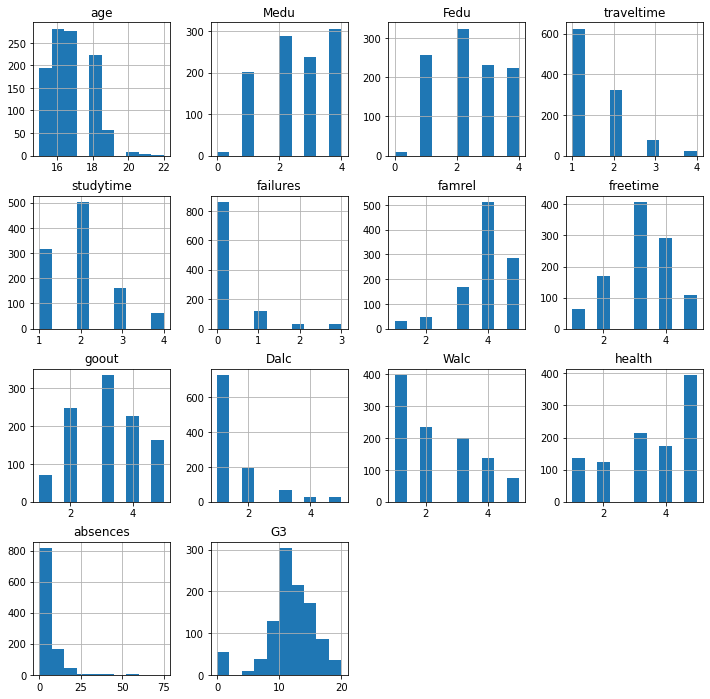

In [8]:

X_train.hist(figsize=(12, 12), bins=10);

<AxesSubplot:>

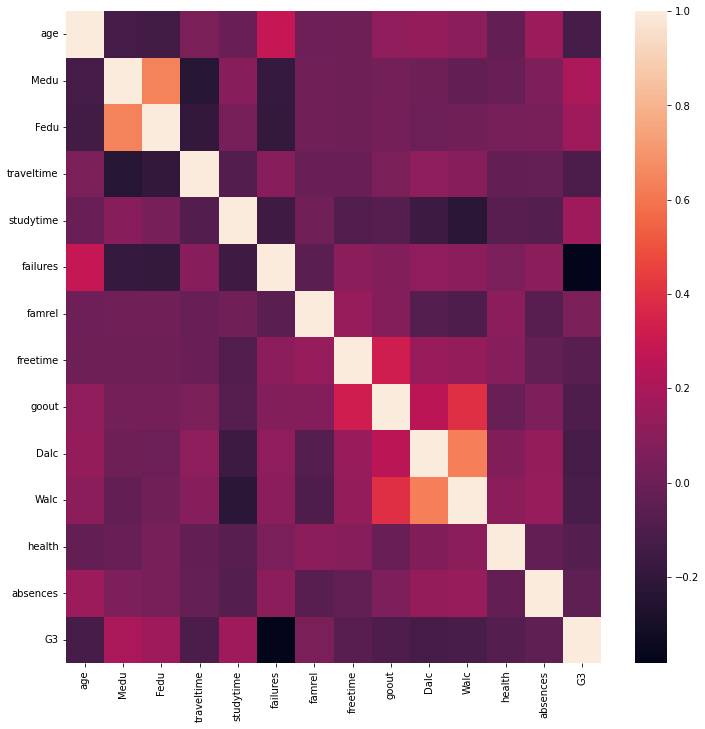

In [9]:
plt.figure(figsize=(12,12))
sns.heatmap(X_train.corr())

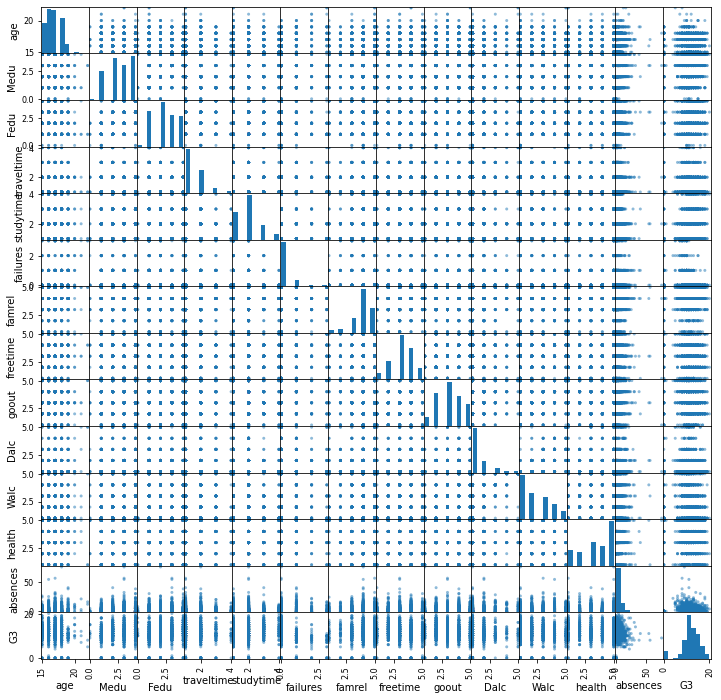

In [10]:
pd.plotting.scatter_matrix(X_train, figsize=(12,12));

Prepare the Data
===

In [37]:
# Cell for preprocessor classes

class RemoveUnwantedFeatures(BaseEstimator, TransformerMixin):
    """
    Drops the unwanted features. Since our target feature is the final grade we will not need
    the first and second semester grades. So this will remove "G1" and "G2".
    """
    def __init__(self, features=None):
        super().__init__()
        self.features = features

    def fit(self, X, y=None, **kwargs):
        
        return self

    def transform(self, X): return X.drop(columns=self.features)


class ConvertNumbersToIntegers(BaseEstimator, TransformerMixin):
    """
    Converts all numerical objects to objects of type int.
    """
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None, **kwargs): return self

    def transform(self, X):
        for column in X.columns:
            if(X[column][0][0] != '"'):
                X[column] = X[column].astype(str).astype(int)
        return X


class LogTransformData(BaseEstimator, TransformerMixin):
    """
    Takes the log of features to convert them from a log distribution to a normal distribution
    """
    def __init__(self, features=None):
        super().__init__()
        self.features = features

    def fit(self, X, y=None, **kwargs): return self

    def transform(self, X):
        for feature in self.features:
            X[feature] = np.log(X[feature]+1)
        return X


class ConvertToDataFrame(BaseEstimator, TransformerMixin):
    """
    After running oneHotEncoder the DateFrame is converted to a numpy array, this function converts the 
    numpy array back into a DataFrame
    """
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None, **kwargs): return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=["school_GP", "school_MS", "sex_F", "sex_M", "address_rural", "address_urban", "famsize_GT3", "famsize_LT3", "Pstatus_apart", "Pstatus_together",
    "Mjob_home", "Mjob_health", "Mjob_other", "Mjob_services", "Mjob_teacher", "Fjob_home", "Fjob_health", "Fjob_other", "Fjob_services", "Fjob_teacher",
    "guardian_father", "guardian_mother", "guardian_other", "reason_course", "reason_other", "reason_home", "reason_reputation", "schoolsup_no", "schoolsup_yes",
    "famsup_no", "famsup_yes", "paid_no", "paid_yes", "activities_no", "activites_yes", "nursery_no", "nursery_yes", "higher_no", "higher_yes",
    "internet_no", "internet_yes", "romantic_no", "romantic_yes", "age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", "freetime",
    "goout", "Dalc", "Walc", "health", "absences"])
        return X


In [43]:
preprocessor = Pipeline([

    ('drop_features', RemoveUnwantedFeatures(features=["G1", "G2"])),
    ('convert_to_int', ConvertNumbersToIntegers()),
    ('log_transform', LogTransformData(features=["traveltime", "failures", "Dalc", "absences"])),

    ('column_transform_one_hot', ColumnTransformer(transformers=[
        ('one_hot_encoder', OneHotEncoder(), ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'guardian', 'reason',
        'schoolsup', 'famsup', 'paid', 'activities','nursery', 'higher', 'internet', 'romantic']),
    ], remainder='passthrough')),
    ('scaler', MinMaxScaler()),
    ('convert_to_dataframe', ConvertToDataFrame())

])


preprocessor.fit_transform(X_train, y_train)

,school_GP,school_MS,sex_F,sex_M,address_rural,address_urban,famsize_GT3,famsize_LT3,Pstatus_apart,Pstatus_together,Mjob_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,guardian_father,guardian_mother,guardian_other,reason_course,reason_other,reason_home,reason_reputation,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activites_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.285714,0.50,0.75,0.442507,0.333333,0.0,0.75,0.75,0.50,0.00000,0.00,0.50,0.253678
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.285714,1.00,0.75,0.442507,0.333333,0.0,1.00,1.00,0.75,0.00000,0.00,0.00,0.000000
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.142857,1.00,0.75,0.756471,0.333333,0.0,1.00,0.75,0.50,0.00000,0.25,0.00,0.253678
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.285714,0.50,1.00,0.000000,0.333333,0.0,1.00,0.75,0.25,0.36907,0.50,1.00,0.000000
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.285714,0.50,0.25,0.756471,0.000000,0.0,0.50,0.25,0.25,0.00000,0.25,1.00,0.507356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.428571,0.25,0.25,0.442507,0.333333,0.0,1.00,0.75,0.75,0.00000,0.00,0.75,0.000000
883,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.142857,0.50,0.25,0.000000,0.333333,0.0,1.00,0.50,0.50,0.00000,0.00,0.00,0.000000
884,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.285714,0.50,0.50,0.000000,0.666667,0.0,0.50,0.75,0.50,0.00000,0.00,0.50,0.507356
885,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.428571,0.25,0.75,0.000000,0.000000,0.0,0.75,0.50,0.50,0.36907,0.50,0.50,0.000000


In [25]:
pd.DataFrame(data.loc()[0])

,0
school,"""GP"""
sex,"""F"""
age,18
address,"""U"""
famsize,"""GT3"""
Pstatus,"""A"""
Medu,4
Fedu,4
Mjob,"""at_home"""
Fjob,"""teacher"""


Short-list Promising
===